# Loading The Required libraries 
### Adding Function To write a report easier and faster.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path, mkdir

filename_ = "tmdb-movies.csv"  # the imdb_csv file name
new_report = [1, 'w']    # case of the report, what to do
name_report = "Report_imdb.txt"  # Name of report file to show the data in


def write_into_report(msg):
    """
    Creates A NEW Report whenever the program Starts .. just to not struggle deleting the old one every time the app
    runs.
    :param msg: the msg to print into the report file
    :return: None
    """
    with open(name_report, new_report[1]) as r:
        r.write(msg)
    if new_report[0]:
        new_report[0] = False
        new_report[1] = 'a+'


# Loading Data Function.
### Removing unneeded columns ['revenue_adj', 'budget_adj'].

In [29]:

def get_data(csv_name):
    """
    :param csv_name: csv filename to analysis
    :return: df : pandas table of csv file
    """
    df = pd.read_csv(csv_name)
    # drop ['revenue_adj', 'budget_adj'] columns to fast the process, as they are not needed
    df.drop(['revenue_adj', 'budget_adj'], axis=1, inplace=True)
    # droping The Duplicated Rows in the table.
    df.drop_duplicates(inplace=True)
    return df

##### remove_rows_containing_null function to get a copy of panda table with only (needed columns) .. to safe descoverly the data without affecting the Main Table

In [30]:
def remove_rows_containing_null(df, list_):
    """
        Creates a copy of the pandas table to remove the na-rows without affecting the original Table
    :param df: pandas table
    :param list_: list of wanted columns from the original table.
    :return table_: the copied - cleared from na-rows table
    """
    table_ = df[list_].copy()
    # Droping the Nan Values to get a cleaner result.
    table_.dropna(inplace=True)
    return table_

## Q1. Since The First Question comes to mind who own an idea .. is how to deliever it ?! .. I see the Answer comes with (what people Like ?) .. So it's reseonable to find whats genre people interesting in .. and also what can pay for the idea (revenue).

In [31]:
def genre_analysis(df):
    """
        Calculate Genre
    :param df: pandas table
    :return:  None
    """
    to_print = f"""{"-" * 40}  \n{" " * 10}Genres Analysis{" " * 10} \n{"-" * 40} \n"""
    df_copy = remove_rows_containing_null(df, ['genres', 'popularity', 'revenue'])
    
    # getting a set of all genres unique values.
    all_genres = set(df_copy.assign(genres=df_copy['genres'].str.split('|')).explode('genres')['genres'].value_counts().index)
    print("all_genres : ",all_genres)

    # calculating how does the genre of the movie affeact the [revenue, popularity]
    genres_calculations = pd.DataFrame(columns=['genre', 'mean_popularity', 'mean_revenue'])
    for genre in all_genres:
        mean_popularity = df_copy[df_copy['genres'].str.contains(genre.title(), case=False)]['popularity'].mean()
        mean_revenue = df_copy['revenue'][df_copy['genres'].str.contains(genre.title(), case=False)].mean()
        got = pd.DataFrame({"genre": [genre], "mean_popularity": [mean_popularity], "mean_revenue": [mean_revenue]})
        genres_calculations = genres_calculations.append(got, ignore_index=True)
    to_print += f"\n{genres_calculations}\n"
    to_print += f"From Genres Mean Analysis [The Max Category] in Popularity : " \
                f"[{genres_calculations['genre'][genres_calculations['mean_popularity'] == genres_calculations['mean_popularity'].max()].values[0]}] " \
                f"- [{round(genres_calculations['mean_popularity'].max(), 3)}]\n"
    to_print += f"From Genres Mean Analysis [The Max Category] in Revenue : " \
                f"[{genres_calculations['genre'][genres_calculations['mean_revenue'] == genres_calculations['mean_revenue'].max()].values[0]}] " \
                f"- [{round(genres_calculations['mean_revenue'].max(), 3)}$]\n"
    
    # ploting the result as pics better describtive.
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.pie(genres_calculations['mean_revenue'], labels=genres_calculations['genre'])
    plt.title("Each Movie Genre in Revenue ")
    plt.savefig('movies_visualization/genre_share_in_mean_revenue', dpi=250)
    plt.show()
    plt.close()
    plt.figure(figsize=(10, 10))
    plt.pie(genres_calculations['mean_popularity'], labels=genres_calculations['genre'])
    plt.title("Each Movie Genre in Popularity ")
    plt.savefig('movies_visualization/genre_share_in_mean_popularity', dpi=250)
    plt.show()
    plt.close()
    to_print += f"Pics (genre_share_in_mean_revenue, genre_share_in_mean_popularity) saved in dir (" \
                f"movies_visualization)\n--->Both results (assures) that"\
                f" [{genres_calculations['genre'][genres_calculations['mean_revenue'] == genres_calculations['mean_revenue'].max()].values[0]}] is the perfect choice of genre to get the [popularity] needed to the product and it's [revenue].\n"
    to_print += "-" * 40 + '\n' + "-" * 40
    print(to_print)
    write_into_report(to_print)
    return


# What Can affect the movie delievering ?! 
##### As It's important to know what can affect ["revenue" , ''popularity"] .. by it's presecense and missing.
That in this function is one of {"revenue" , "popularity"} .. and against is from this list {homepage, keywords, tagline, imdb}

In [32]:
def null_against_that(df, against, that, msg=''):
    """
        Analysing the effect of the absence of (against) on (that) ..
    :param df: Pandas Table
    :param against: what we want to compare it's absence with it's presence on (param: that).
    :param that: what we want to get results about .. within the change of (against).
    :param msg: 'text' to appear in report and print-func to get clearer results. (optional)
    :return:  None
    """
    # Making Sure That imdb print clearer in the report.
    if against[:4] == "imdb":
        against_name = "IMDB"
    else:
        against_name = against
    to_print = "-"*40 + '\n' + that.capitalize() + ' <vs> [absence] ' + against_name.capitalize() + '\n' + "-"*40 + '\n'
    
    
    # The Values calculation of [that] (with or without) [against] .. 
    #to take a better decision for what is needed to be done to get the desired goals  
    
    is_null_min = df[that][df[against].isna()].min()
    not_null_min = df[that][df[against].isna() == False].min()
    is_null_mean = df[that][df[against].isna()].mean()
    not_null_mean = df[that][df[against].isna() == False].mean()
    is_null_max = df[that][df[against].isna()].max()
    not_null_max = df[that][df[against].isna() == False].max()
    to_print += f"min {that} of movies (without) {against} : {is_null_min}\n" \
                f"min {that} of movies with {against} : {not_null_min}\n" \
                f"avg {that} of movies (without) {against} : {is_null_mean}\n" \
                f"avg {that} of movies with {against} : {not_null_mean}\n" \
                f"max {that} of movies (without) {against} : {is_null_max}\n" \
                f"max {that} of movies with {against} : {not_null_max}\n"
    
    # if the results with [aganist] better .. it prints the values.
    if not_null_max > is_null_max and not_null_mean > is_null_mean:
        to_print += f"-------> movie ({msg}) [[affects]] the {that} Directly\n" \
                    f"An Image called {against_name}_{that} is produced in dir (movies_visualization) " \
                    f"to see the graph of (avg) values. \n\n"

        locations = [1, 2]
        heights = [df[that][df[against].isna()].mean(), df[that][df[against].isna() == False].mean()]
        labels = [f"No {against_name.capitalize()}", f"With {against_name.capitalize()}"]
        
        # show the result.
        plt.bar(locations, heights, tick_label=labels, color=['black', 'cyan'])
        plt.title(f"[{against_name.capitalize()}] on Avg {that}")
        plt.ylabel(that)
        plt.xlabel('Absence vs Presence')
        plt.savefig(f"movies_visualization/{against_name}_{that}")
        plt.show()

    
    # this condition actually hadn't happen in this data base .. 
    # since all [against] that i have compared with [that] was needed to get a better [that]
    else:
        to_print += f"Since the Difference isn't really observed .. ({against}) is optional."
    print(to_print)
    to_print += "*" * 40 + '\n'
    write_into_report(to_print)


### To organize Q1 .. For a person who owns an idea it's important to know which industry is Evolving more .. and that's appears by how many product .. as if the number of products increase in a market .. this show that (The Market needs more .. and needs better).

In [33]:
def industry_evolving(df):
    """
        Analysing The Evolving of Movies Production Per Years.
    :param df: Pandas Table
    :return:  None
    """

    years_arr = np.array(df['release_year'])[::-1].tolist()
    unique_years = np.unique(years_arr)
    years_counted = [years_arr.count(i) for i in unique_years]
    
    
    # Ploting How much The market Evolves.
    plt.bar(unique_years, years_counted, visible=True)
    plt.title('Movies Production Per Years')
    plt.ylabel('Movies Quantity')
    plt.xlabel('Years of Production')
    plt.xlim([unique_years[0]-1, unique_years[-1]+2])

    plt.savefig("movies_visualization/quantity_movies_per_year")
    plt.show()

    to_print = f"\n{'*'*40}\nMax no of movies from sheet in one year [{max(years_counted)} Movies] at" \
               f" [{unique_years[years_counted.index(max(years_counted))]}]\n"
    to_print += f"pic (quantity_movies_per_year) is saved in (movies_visualization) folder to illustrate how Media " \
                f"Evolves per time.\nAs The Market is Evolving As it's Appearing in the pic .. "\
                f"The opportunities also evolves.\n{'-'*40}\n{'-'*40} "
    print(to_print)
    write_into_report(to_print)


###### Runing all the analysis once in (get_analyze).

In [34]:
def get_analyze(df):
    """
    It's Like The Main Function for Analysing Process for arranging.
    :param df: Pandas Table
    :return:  None
    """
    # print("df.shape = ", df.shape)
    # see the avg result value of existing [homepage,keywords,tagline] on revenue
    print("*" * 40, '\n')
    null_against_that(df, 'homepage', "revenue", "Domain Homepage")
    null_against_that(df, 'keywords', "revenue", '[specified - clear] keywords')
    null_against_that(df, 'tagline', "revenue", '[specified - clear] tagline')
    null_against_that(df, 'imdb_id', 'popularity', "on IMDB Site")
    print()

    # show how genre affect both ['popularity', 'revenue'].
    print("*" * 40, '\n')
    genre_analysis(df)

    # show how much movies production evolves per years.
    industry_evolving(df)

In [35]:
# main running function.
def main():
    if not path.isdir('movies_visualization'):
        mkdir('movies_visualization')
    write_into_report("+" * 20 + "IMDB REPORT" + "+" * 20 + '\n' * 2)
    df = get_data(filename_)
    get_analyze(df)

**************************************** 



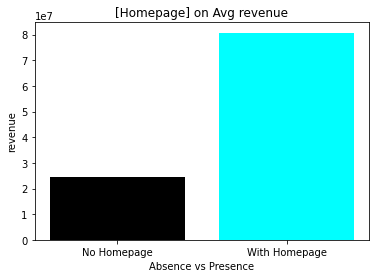

----------------------------------------
Revenue <vs> [absence] Homepage
----------------------------------------
min revenue of movies (without) homepage : 0
min revenue of movies with homepage : 0
avg revenue of movies (without) homepage : 24674822.03783579
avg revenue of movies with homepage : 80746785.40088555
max revenue of movies (without) homepage : 1106279658
max revenue of movies with homepage : 2781505847
-------> movie (Domain Homepage) [[affects]] the revenue Directly
An Image called homepage_revenue is produced in dir (movies_visualization) to see the graph of (avg) values. 




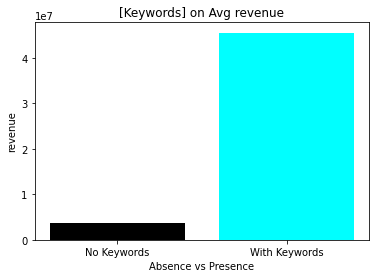

----------------------------------------
Revenue <vs> [absence] Keywords
----------------------------------------
min revenue of movies (without) keywords : 0
min revenue of movies with keywords : 0
avg revenue of movies (without) keywords : 3726346.621567314
avg revenue of movies with keywords : 45577869.2241784
max revenue of movies (without) keywords : 431971116
max revenue of movies with keywords : 2781505847
-------> movie ([specified - clear] keywords) [[affects]] the revenue Directly
An Image called keywords_revenue is produced in dir (movies_visualization) to see the graph of (avg) values. 




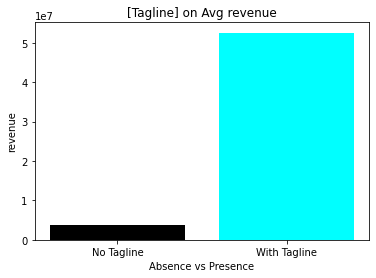

----------------------------------------
Revenue <vs> [absence] Tagline
----------------------------------------
min revenue of movies (without) tagline : 0
min revenue of movies with tagline : 0
avg revenue of movies (without) tagline : 3669105.9854815863
avg revenue of movies with tagline : 52525515.55428429
max revenue of movies (without) tagline : 886686817
max revenue of movies with tagline : 2781505847
-------> movie ([specified - clear] tagline) [[affects]] the revenue Directly
An Image called tagline_revenue is produced in dir (movies_visualization) to see the graph of (avg) values. 




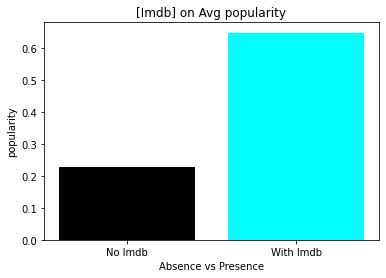

----------------------------------------
Popularity <vs> [absence] Imdb
----------------------------------------
min popularity of movies (without) imdb_id : 0.004323
min popularity of movies with imdb_id : 6.5e-05
avg popularity of movies (without) imdb_id : 0.22645900000000002
avg popularity of movies with imdb_id : 0.6468324609857206
max popularity of movies (without) imdb_id : 0.607851
max popularity of movies with imdb_id : 32.985763
-------> movie (on IMDB Site) [[affects]] the popularity Directly
An Image called IMDB_popularity is produced in dir (movies_visualization) to see the graph of (avg) values. 



**************************************** 

all_genres :  {'Foreign', 'Adventure', 'Animation', 'TV Movie', 'Mystery', 'Western', 'Romance', 'Thriller', 'Fantasy', 'History', 'Drama', 'Documentary', 'Music', 'Action', 'Science Fiction', 'Horror', 'Crime', 'War', 'Comedy', 'Family'}


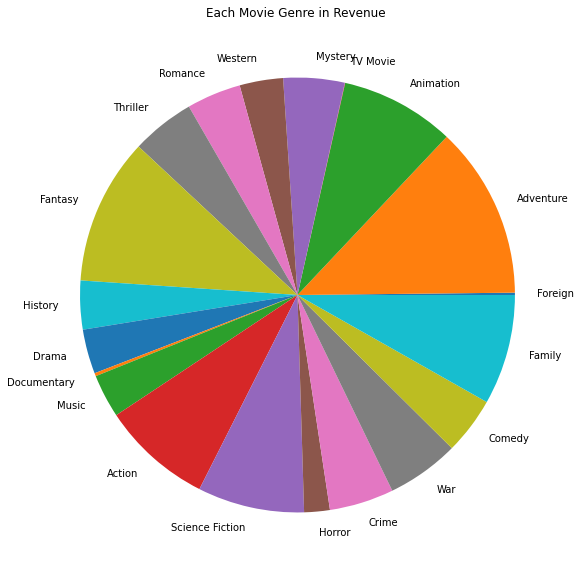

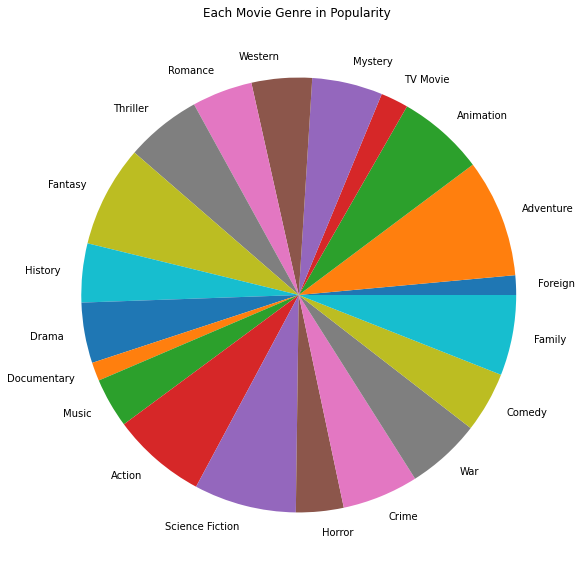

----------------------------------------  
          Genres Analysis           
---------------------------------------- 

              genre  mean_popularity  mean_revenue
0           Foreign         0.191496  1.520460e+06
1         Adventure         1.154259  1.131379e+08
2         Animation         0.852182  7.525606e+07
3          TV Movie         0.270896  2.514970e+05
4           Mystery         0.690012  4.021757e+07
5           Western         0.590615  2.856871e+07
6           Romance         0.592082  3.569197e+07
7          Thriller         0.741563  4.172842e+07
8           Fantasy         0.992840  9.631366e+07
9           History         0.575936  3.201179e+07
10            Drama         0.591495  2.923226e+07
11      Documentary         0.181432  2.041107e+06
12            Music         0.487321  2.857177e+07
13           Action         0.926274  7.279473e+07
14  Science Fiction         1.001548  7.014056e+07
15           Horror         0.465357  1.682281e+07
16        

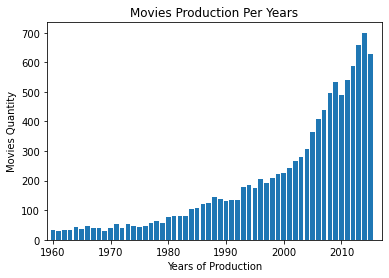


****************************************
Max no of movies from sheet in one year [700 Movies] at [2014]
pic (quantity_movies_per_year) is saved in (movies_visualization) folder to illustrate how Media Evolves per time.
As The Market is Evolving As it's Appearing in the pic .. The opportunities also evolves.
----------------------------------------
---------------------------------------- 


In [36]:
if __name__ == "__main__":
    main()